In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reach_given_mean
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, 6)

In [5]:
len(data_tr[2])

75208

In [6]:
print(np.mean(data_tr[2]))
data_tr = reach_given_mean(data_tr, np.mean(y_te_te))
print(np.mean(data_tr[2]))

0.21727741729603234
0.2034451029742091


In [7]:
type(data_vl)

list

In [8]:
len(data_tr[2])

73902

In [9]:
len(data_te_tr[2])

37564

In [10]:
print(np.mean(data_te_tr[2]))
data_te_tr = reach_given_mean(data_te_tr, np.mean(y_te_te))
print(np.mean(data_te_tr[2]))

0.21858694494728995
0.20342478764688324


In [11]:
len(data_te_tr[2])

36849

In [12]:
len(y_te_te)

1222

In [13]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.2034451029742091
0.20701168614357263

0.20342478764688324
0.19522240527182866
0.20294599018003273


In [14]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.028, identitity_weight_decay=0.96)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2311/2310 | loss 1.1808 | val loss 0.7727 | acc 0.2070 | f1 0.3430 | prec 0.2070 | recall 1.0000 | roc auc 0.5157 | pr auc 0.2675 | elapsed 38.15s
train epoch 01/15 | batch 2311/2310 | loss 0.8185 | val loss 0.4483 | acc 0.8287 | f1 0.4616 | prec 0.6604 | recall 0.3548 | roc auc 0.7344 | pr auc 0.5578 | elapsed 123.04s
train epoch 02/15 | batch 2311/2310 | loss 0.4830 | val loss 0.3904 | acc 0.8456 | f1 0.5795 | prec 0.6641 | recall 0.5141 | roc auc 0.8045 | pr auc 0.6608 | elapsed 125.65s
train epoch 03/15 | batch 2311/2310 | loss 0.3279 | val loss 0.3736 | acc 0.8581 | f1 0.6352 | prec 0.6789 | recall 0.5968 | roc auc 0.8392 | pr auc 0.7224 | elapsed 121.06s
train epoch 04/15 | batch 2311/2310 | loss 0.2295 | val loss 0.3438 | acc 0.8712 | f1 0.6727 | prec 0.7100 | recall 0.6391 | roc auc 0.8674 | pr auc 0.7678 | elapsed 126.06s
train epoch 05/15 | batch 2311/2310 | loss 0.18

In [15]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 0001/1152 | loss 1.3686 | elapsed 0.01s

train epoch 00/10 | batch 1153/1152 | loss 1.2370 | val loss 1.5608 | acc 0.6021 | f1 0.3878 | prec 0.2772 | recall 0.6456 | roc auc 0.6716 | pr auc 0.3972 | elapsed 9.92s
train epoch 01/10 | batch 1153/1152 | loss 1.0294 | val loss 1.1407 | acc 0.6557 | f1 0.4129 | prec 0.3095 | recall 0.6203 | roc auc 0.7124 | pr auc 0.4675 | elapsed 26.51s
train epoch 02/10 | batch 1153/1152 | loss 0.6668 | val loss 0.8643 | acc 0.7158 | f1 0.4584 | prec 0.3650 | recall 0.6160 | roc auc 0.7503 | pr auc 0.5366 | elapsed 26.55s
train epoch 03/10 | batch 1153/1152 | loss 0.4407 | val loss 0.6825 | acc 0.7578 | f1 0.4983 | prec 0.4183 | recall 0.6160 | roc auc 0.7860 | pr auc 0.5931 | elapsed 26.09s
train epoch 04/10 | batch 1153/1152 | loss 0.3083 | val loss 0.5640 | acc 0.7957 | f1 0.5507 | prec 0.4825 | recall 0.6414 | roc auc 0.8176 | pr auc 0.6422 | elapsed 25.61s
train epoch 05/10 | batch 1153/1152 | loss 0.2315 | val loss 0.4855 | acc 0.8221 | f1 0.5878 | prec 0.5366 | recall 0.6498 | roc auc 0.8

In [16]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240723T222335


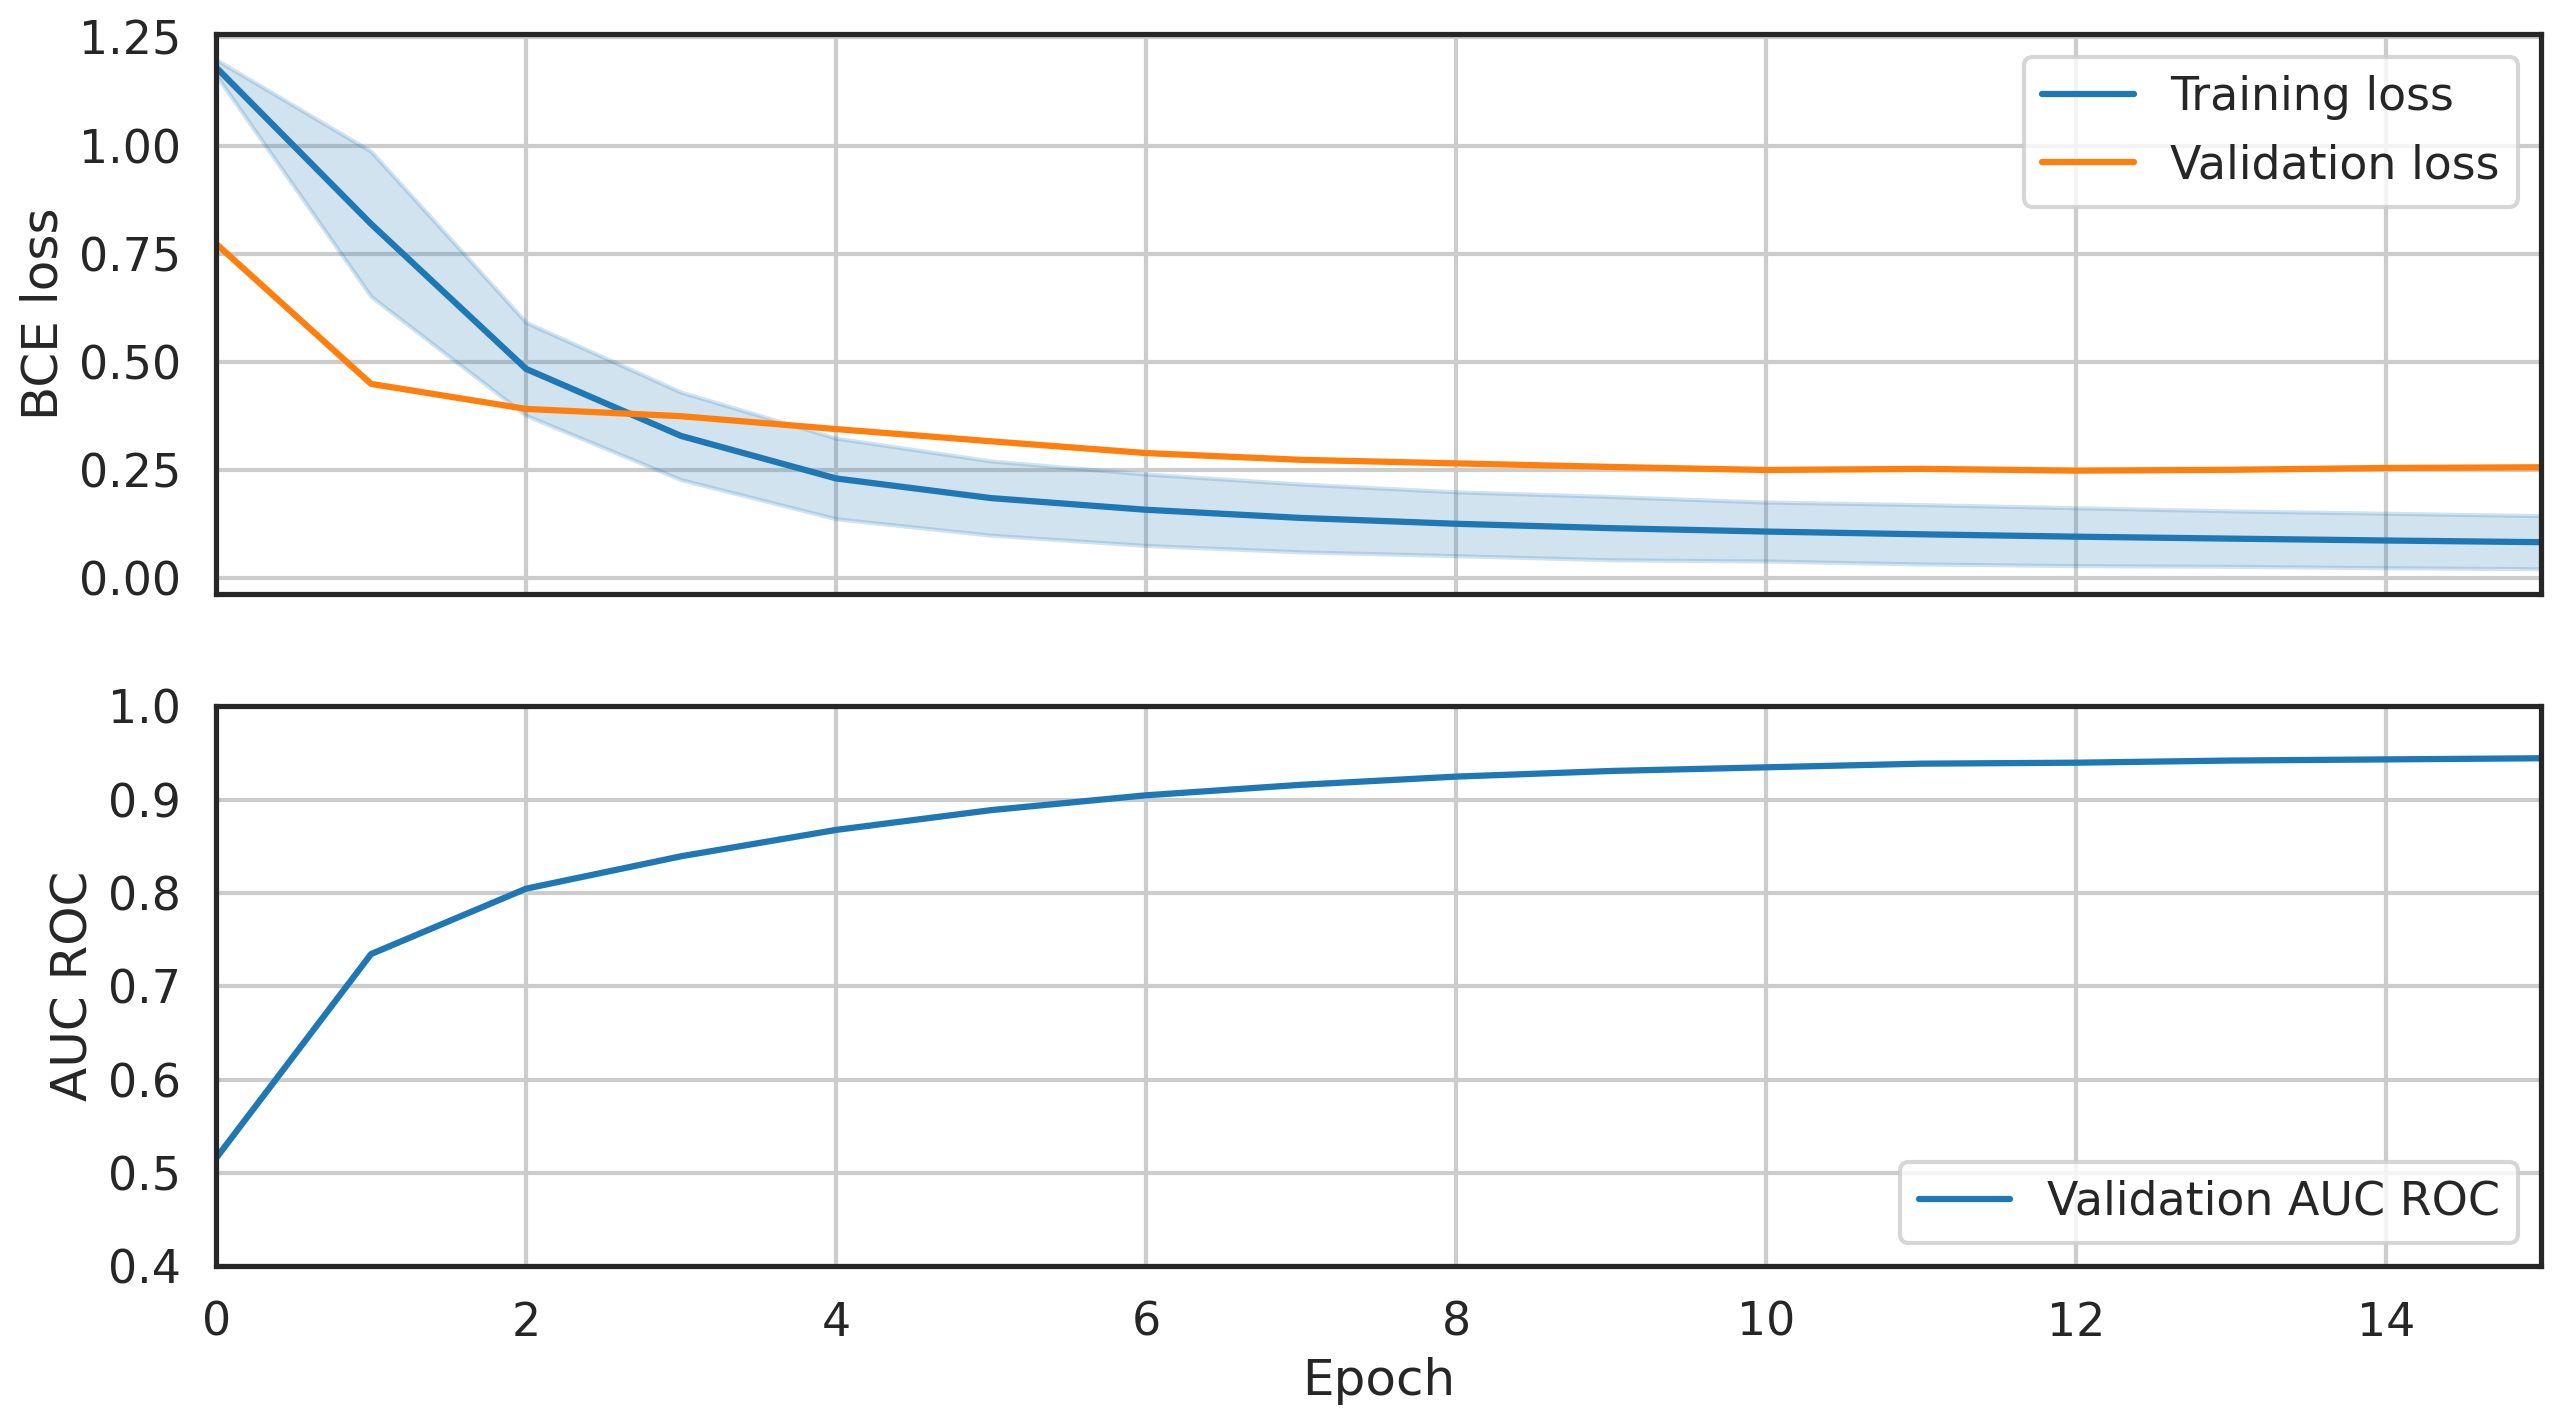

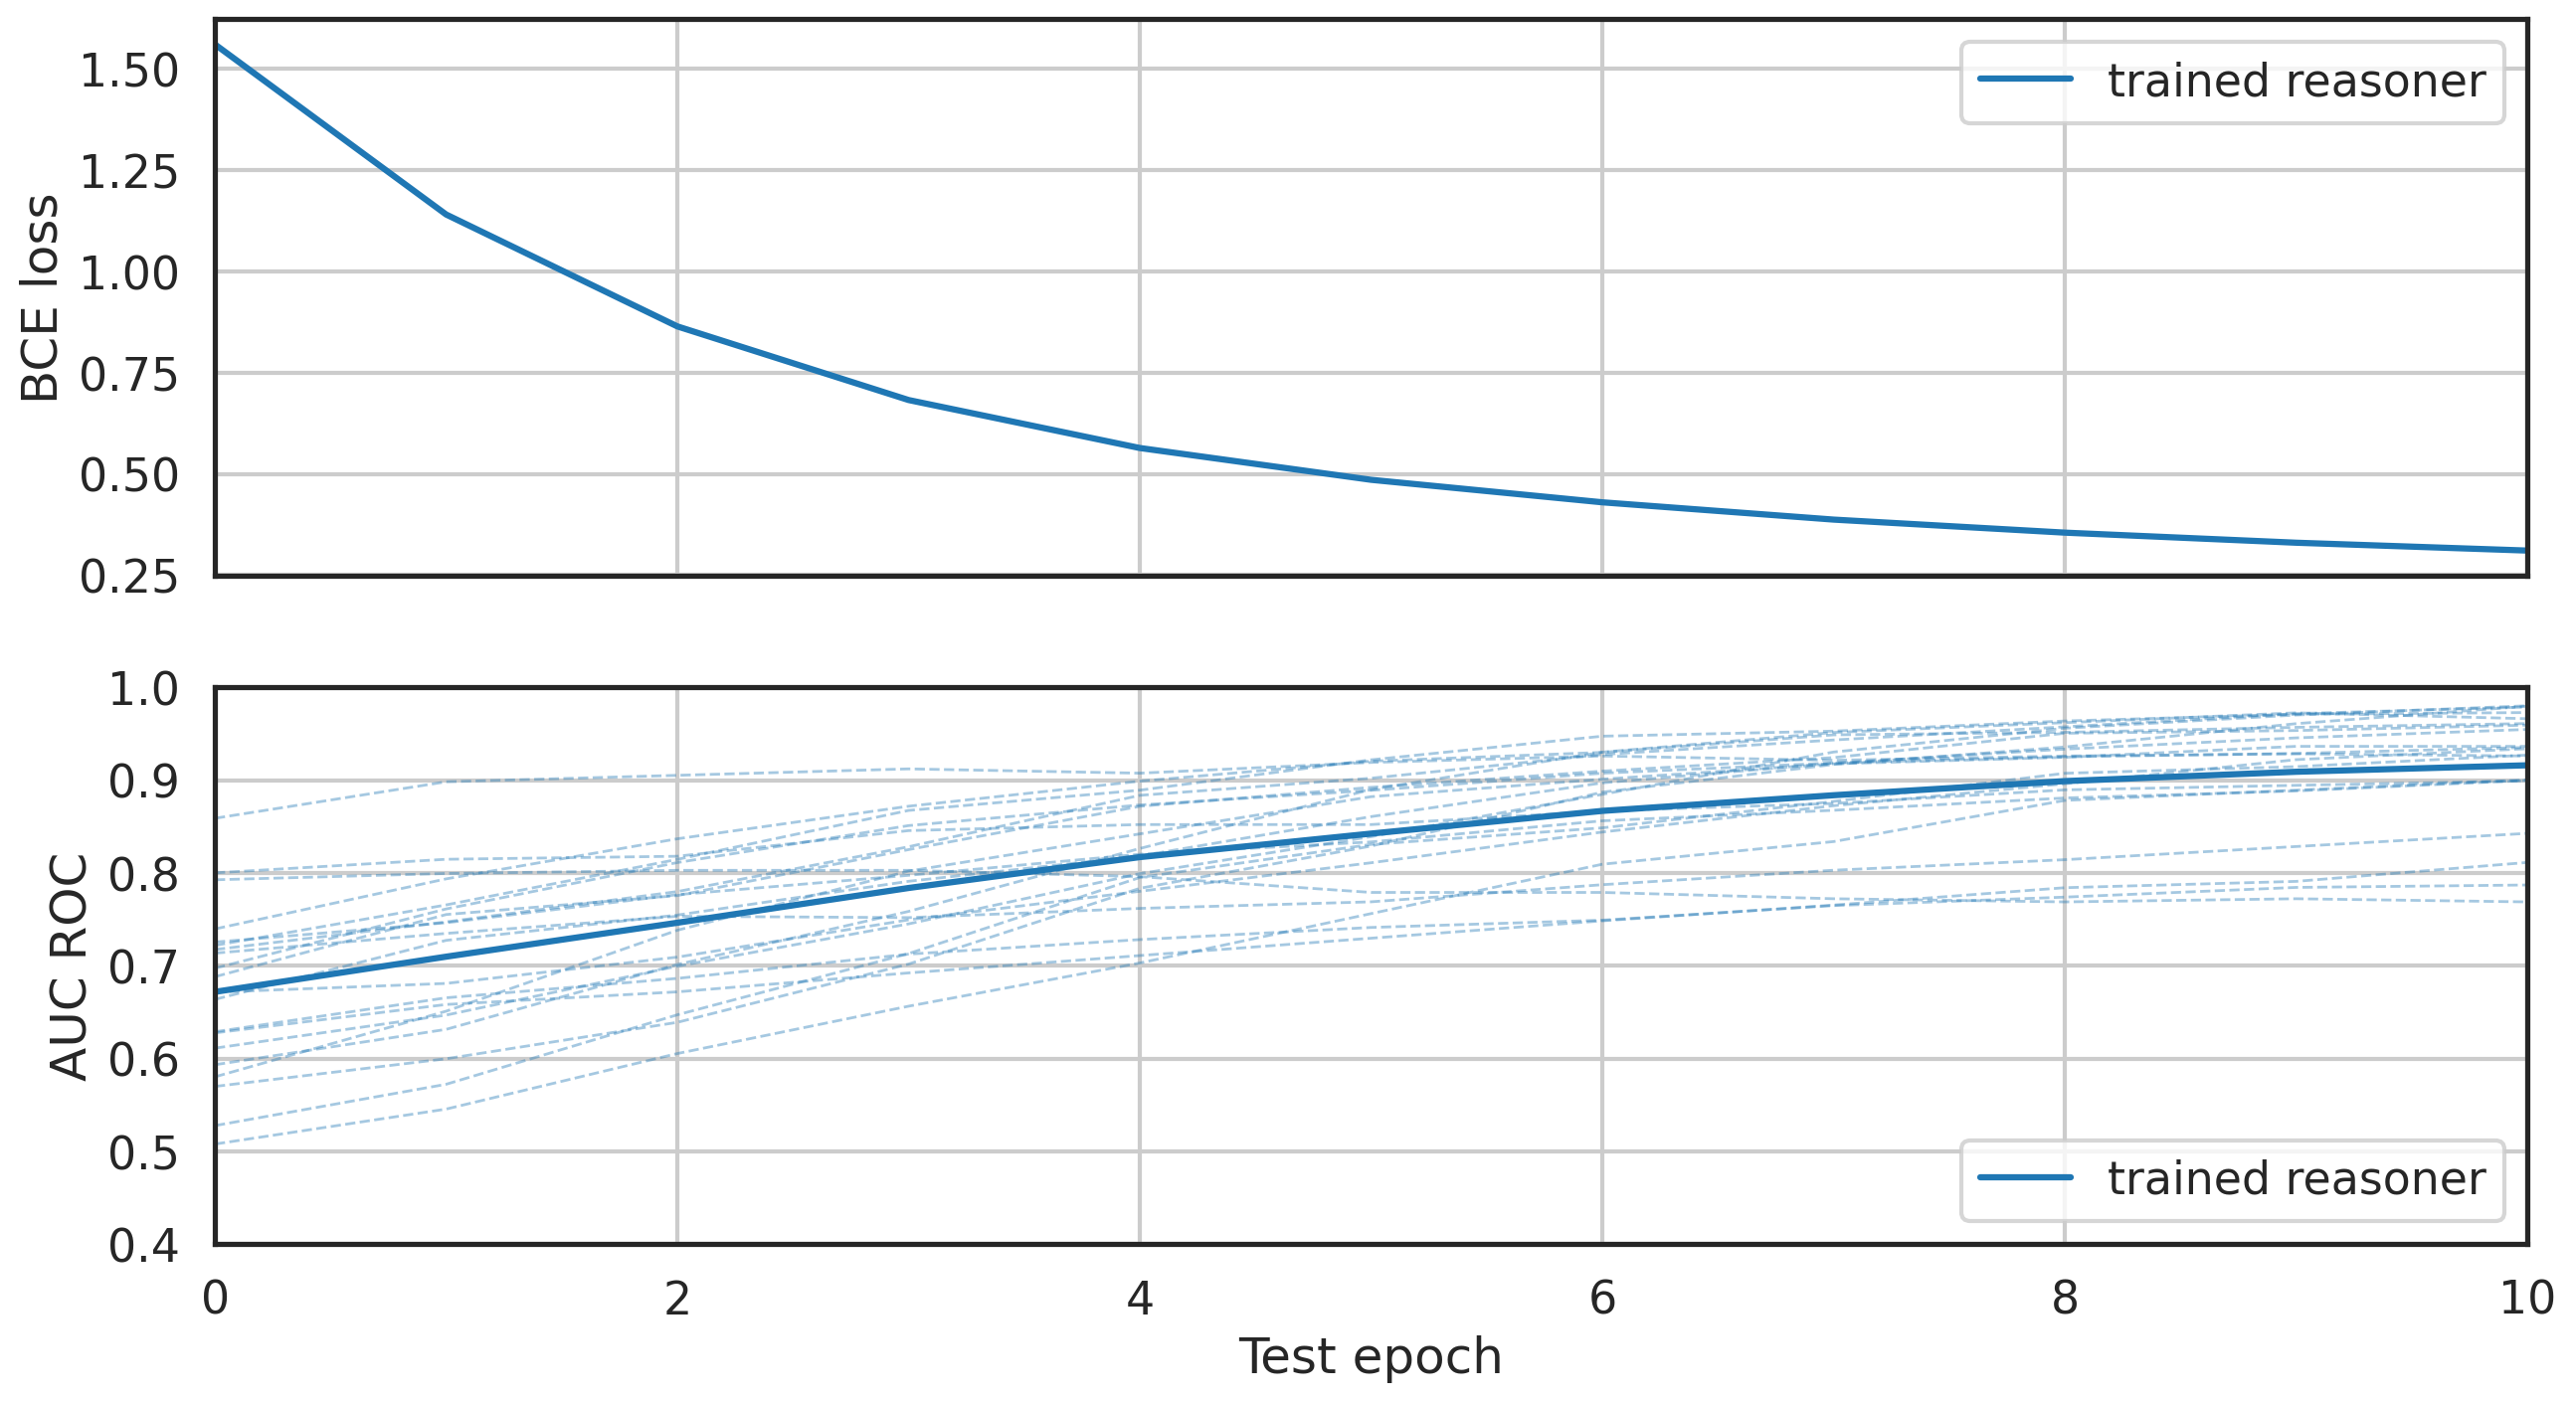

             mean       std     micro
acc      0.911345  0.045709  0.911620
prec     0.763857  0.150648  0.771318
recall   0.786241  0.167029  0.802419
f1       0.763473  0.131805  0.786561
auc_roc  0.938359  0.049425  0.941892
auc_pr   0.856307  0.116057  0.873889


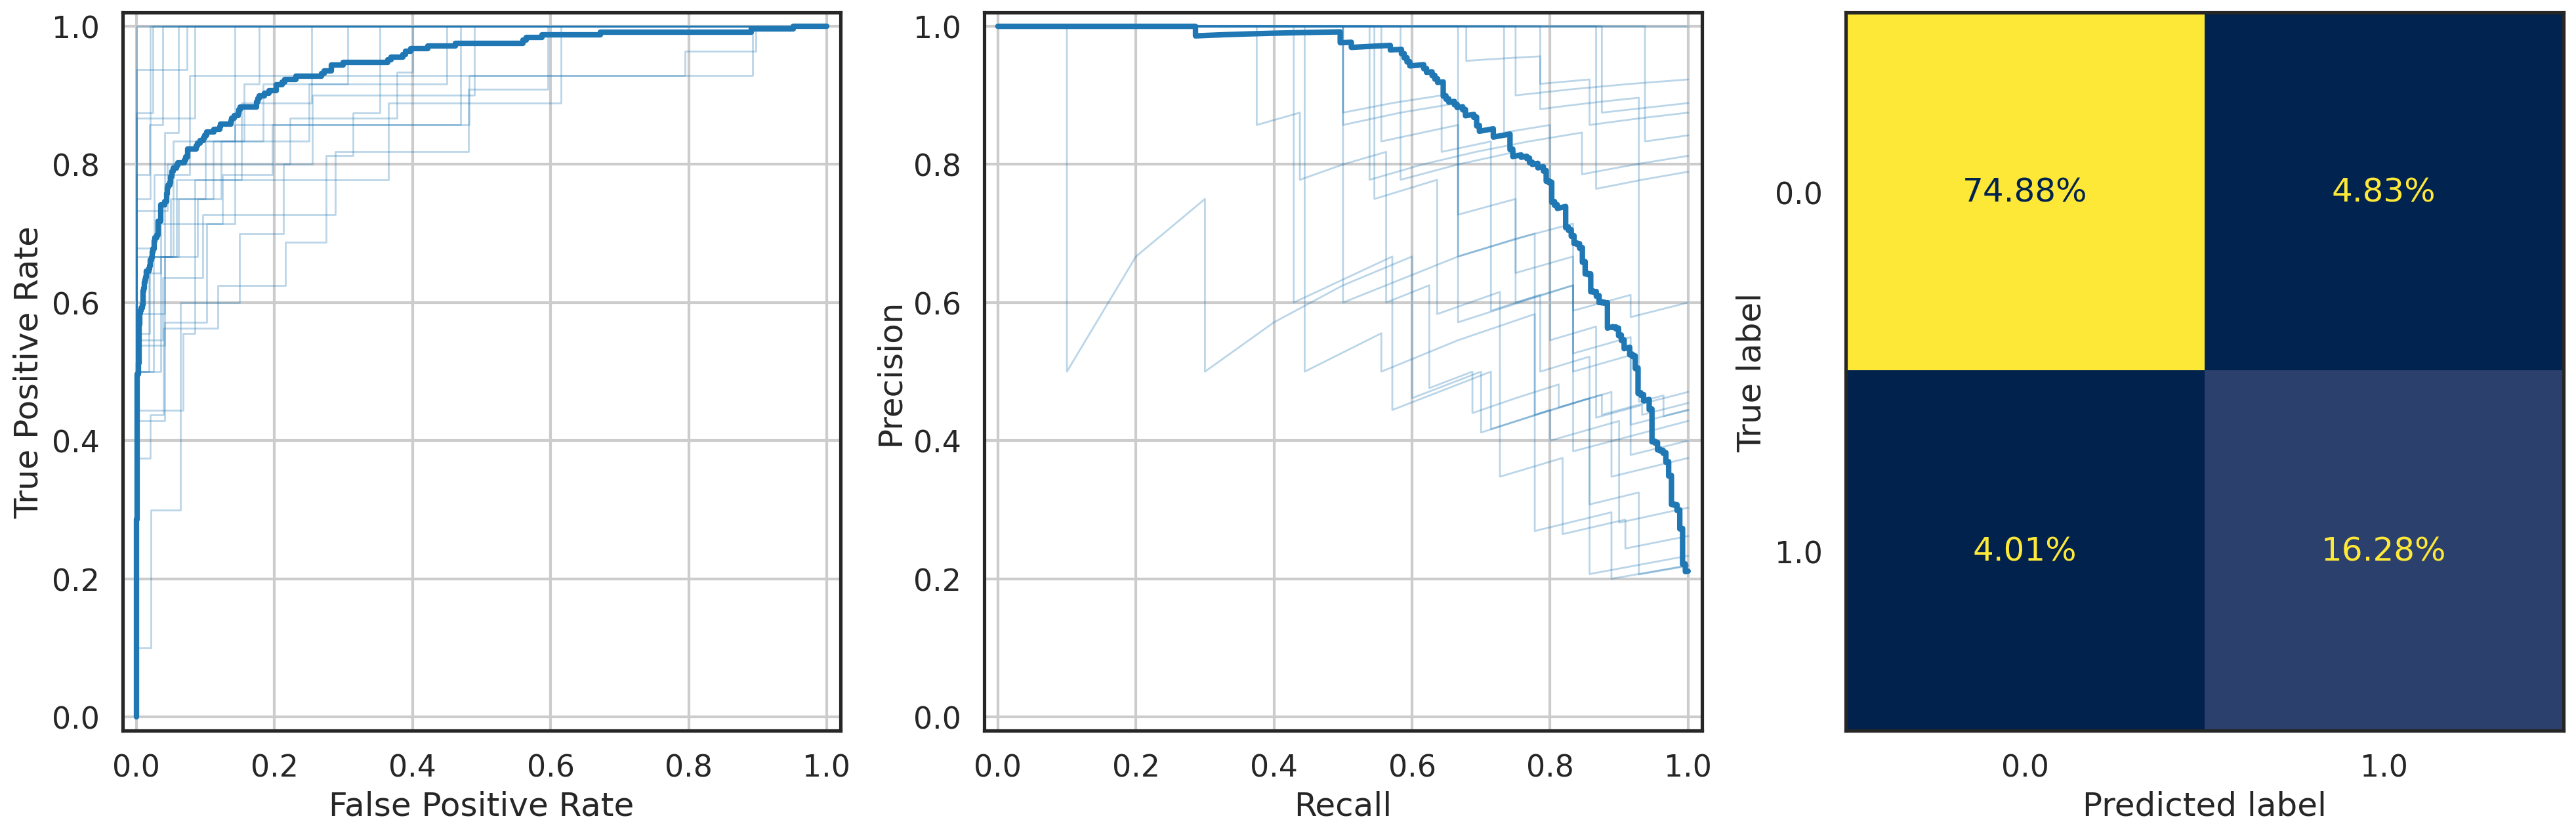

In [17]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [18]:
import random

In [19]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [22]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []
losses_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [23]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.000012
  Std Dev Loss: 0.000004
  Mean Diff: 0.000029
  Std Dev Diff: 0.000011

Duality of Top and Bottom:
  Mean Loss: 0.000560
  Std Dev Loss: 0.000000
  Mean Diff: 0.001169
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.106205
  Std Dev Loss: 0.027361
  Mean Diff: 0.252031
  Std Dev Diff: 0.072417

Associativity:
  Mean Loss: 0.018384
  Std Dev Loss: 0.006419
  Mean Diff: 0.041927
  Std Dev Diff: 0.014800

Commutativity:
  Mean Loss: 0.022108
  Std Dev Loss: 0.008357
  Mean Diff: 0.052440
  Std Dev Diff: 0.020883

Contradiction:
  Mean Loss: 0.128043
  Std Dev Loss: 0.034698
  Mean Diff: 0.209718
  Std Dev Diff: 0.044925

Identity with Top:
  Mean Loss: 0.063290
  Std Dev Loss: 0.018022
  Mean Diff: 0.149796
  Std Dev Diff: 0.047378

Absorption by Bottom:
  Mean Loss: 0.014949
  Std Dev Loss: 0.006306
  Mean Diff: 0.034008
  Std Dev Diff: 0.012595

Top Concept Subsumption:
  Mean Loss: 0.001329
  Std Dev Loss: 0.001441
  Mean Diff: N/A
  Std De